In [35]:
import requests
import json
import time
from datetime import datetime
import pandas as pd
from imblearn.over_sampling import SMOTE
import math

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score


In [37]:
# !pip3 install seaborn

In [38]:
# !pip3 install imblearn

In [39]:
import seaborn as sn

In [40]:
import numpy as np
from numpy import savetxt
from numpy import asarray
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join

# Data description
- The data is collected from benchmark, simulated malware and simulated stress application
- 12 metrics are listed as below:
 
 - 0) **cpu_system**: The “system” CPU state shows the amount of CPU time used by the kernel. The kernel is responsible for low-level tasks, like interacting with the hardware, memory allocation, communicating between OS processes, running device drivers and managing the file system.
 - 1) **cpu_idle**: The “idle” CPU state shows the CPU time that’s not actively being used. **=> cpu_total = 1- cpu_idle**: is the total consumption of CPU 
 - 2) **cpu_user**: The "user" CPU state shows CPU time used by user space processes. These are higher-level processes, like your application, or the database server running on your machine.
 - 3) **cpu_iowait**: The "iowait" is a sub category of the “idle” state. It marks time spent waiting for input or output operations, like reading or writing to disk
 - 4) **pod_count**: Num of pod services controlled by Kubernettes
 - 5) **system_load**: The load of a system is essentially the number of processes active at any given time. When idle, the load is 0. When a process starts, the load is incremented by 1
 - 6) **mem_total**: Total amount of Memory
 - 7) **mem_avail**: Total amount of free mem
 - 8) **disk_io**: Disk I/O includes read or write or input/output operations (defined in KB/s) involving a physical disk. In simple words, it is the speed with which the data transfer takes place between the hard disk drive and RAM, or basically it measures active disk I/O time
 - 9) **disk_space_used**: refers to the portion or percentage of computer storage that is currently in use
 - 10) **net_received**
 - 11) **net_transmit**

Other metrics related to timestamp
 - 12) timestamp (is the index of pandas)
 - 13) year
 - 14) month
 - 15) day
 - 16) hour
 - 17) minute
 - 18) second

 Classified by metric : label with 0 and 1
 
 Ref:
 https://blog.appsignal.com/2018/03/06/understanding-cpu-statistics.html
 https://blog.appsignal.com/2018/03/28/understanding-system-load-and-load-averages.html

In [41]:
# !rm -rf CBT
# !git clone https://github.com/levanthanh3005/CBT

In [42]:
def viewAllDataFromFolder(dataPath,prefix):
    onlyfiles = [f for f in listdir(dataPath) if isfile(join(dataPath, f))]
    count = 0
    fileLs = []
    lsBdTrain = None
    dataList = []
    for fs in onlyfiles:
        if fs[:2]==prefix:
#             print(fs)
            count = count + 1
            dataItem = pd.read_pickle(dataPath+"/"+fs)
            dataList.append(dataItem)
    frame = pd.concat(dataList)
    return frame

In [43]:
dataset = viewAllDataFromFolder("CBT/data","8-")
#Good Result at 1629489780:

In [44]:
dataset = dataset.reset_index().fillna(0)

In [45]:
dataset.head()

,index,timestamp,cpu_system,cpu_idle,cpu_user,cpu_iowait,pod_count,system_load,mem_total,mem_avail,disk_io,disk_space_used,net_received,net_transmit,node,label,second
0,0.0,1.629576e+09,0.024000,0.906000,0.052667,0.000333,6.0,0.12,1.911521e+09,2.174521e+09,0.005067,0.534038,951905.066667,899240.000000,tan-k2,1,0.0
1,1.0,1.629576e+09,0.024000,0.906000,0.052667,0.000333,6.0,0.12,1.911521e+09,2.174521e+09,0.005067,0.534038,951905.066667,899240.000000,tan-k2,1,8.0
2,2.0,1.629576e+09,0.034333,0.895667,0.045667,0.003000,6.0,0.10,1.911755e+09,2.174288e+09,0.010400,0.534295,771843.200000,541984.000000,tan-k2,1,16.0
3,3.0,1.629576e+09,0.034333,0.895667,0.045667,0.003000,6.0,0.10,1.911755e+09,2.174288e+09,0.010400,0.534295,771843.200000,541984.000000,tan-k2,1,24.0
4,4.0,1.629576e+09,0.025000,0.908000,0.045000,0.000000,6.0,0.07,1.911210e+09,2.174833e+09,0.000800,0.534296,849244.266667,771101.333333,tan-k2,1,32.0


# Data Shape and Label Count

In [46]:
print("Data Shape",dataset.shape)
print("Label counts:")
print(dataset["label"].value_counts())
print("8 data item per 1 minute")
print((dataset.shape[0] / 8)/60," hours")
print(((dataset.shape[0] / 8)/60)/24," days")
print("Num of data item with 10 min:",(dataset.shape[0] / 8)/10)

Data Shape (295512, 17)
Label counts:
1    239423
0     56089
Name: label, dtype: int64
8 data item per 1 minute
615.65  hours
25.652083333333334  days
Num of data item with 10 min: 3693.9


# Rebalance data

In [47]:
def resampleData(dataset,label):
    dataX = dataset.drop(label, axis=1)
    dataY = dataset[label]
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(dataX, dataY)
    result = pd.concat([X_res, y_res], axis=1)
    return result

# Data Overview

In [48]:
dataset["timemm"] = dataset['timestamp']
dataset['timemm'] = dataset['timemm'].apply(lambda x: datetime.fromtimestamp(x))
dataset["year"] = dataset['timemm'].apply(lambda x:x.year)
dataset["month"] = dataset['timemm'].apply(lambda x:x.month)
dataset["day"] = dataset['timemm'].apply(lambda x:x.day)
dataset["hour"] = dataset['timemm'].apply(lambda x:x.hour)
dataset["minute"] = dataset['timemm'].apply(lambda x:x.minute)
dataset["second"] = dataset['timemm'].apply(lambda x:x.second)
del dataset['timemm']

dataset["node"] = dataset["node"].apply(lambda x : 2 if x=="tan-k2" else 3 if x=="tan-k3" else 1 if x=="tan-km" else x)
dataset["cpu_total"] = 1 - dataset["cpu_idle"]

dataset["cpu_user_rate"] = dataset["cpu_user"] / dataset["cpu_total"]
dataset["cpu_system_rate"] = dataset["cpu_system"] / dataset["cpu_total"]

dataset["mem_used"] = dataset["mem_total"]
dataset["mem_total"] = dataset["mem_used"] + dataset["mem_avail"]

# dataset["mem_used_rate"] = dataset["mem_used"] / dataset["mem_total"]
# dataset["mem_avail_rate"] = dataset["mem_avail"] / dataset["mem_total"]



## Proprotion of nodes

In [49]:
print(dataset["node"].value_counts())
dataset.head()

3    99465
2    99465
1    96582
Name: node, dtype: int64


,index,timestamp,cpu_system,cpu_idle,cpu_user,cpu_iowait,pod_count,system_load,mem_total,mem_avail,...,second,year,month,day,hour,minute,cpu_total,cpu_user_rate,cpu_system_rate,mem_used
0,0.0,1.629576e+09,0.024000,0.906000,0.052667,0.000333,6.0,0.12,4.086043e+09,2.174521e+09,...,0,2021,8,21,20,6,0.094000,0.560284,0.255319,1.911521e+09
1,1.0,1.629576e+09,0.024000,0.906000,0.052667,0.000333,6.0,0.12,4.086043e+09,2.174521e+09,...,8,2021,8,21,20,6,0.094000,0.560284,0.255319,1.911521e+09
2,2.0,1.629576e+09,0.034333,0.895667,0.045667,0.003000,6.0,0.10,4.086043e+09,2.174288e+09,...,16,2021,8,21,20,6,0.104333,0.437700,0.329073,1.911755e+09
3,3.0,1.629576e+09,0.034333,0.895667,0.045667,0.003000,6.0,0.10,4.086043e+09,2.174288e+09,...,24,2021,8,21,20,6,0.104333,0.437700,0.329073,1.911755e+09
4,4.0,1.629576e+09,0.025000,0.908000,0.045000,0.000000,6.0,0.07,4.086043e+09,2.174833e+09,...,32,2021,8,21,20,6,0.092000,0.489130,0.271739,1.911210e+09


In [50]:
def normalizeColumn(datas):
    datas2 = datas.copy()
    cols = datas2.columns
    for e in range(0,14):
        print(e," ",cols[e])
        normalized_df=(datas2[cols[e]]-datas2[cols[e]].mean())/datas2[cols[e]].std()
        datas2[cols[e]] = normalized_df
    return datas2

def viewMetric(metric, datas):
    ndf = datas[[metric,"label","node"]]
#     print("View each label in a graph and put them next to others")
#     print("Calculate min max std ..")
    ndf0 = ndf[ndf["label"]==0]
    ndf1 = ndf[ndf["label"]==1]

    fig, (ax0, ax1) = plt.subplots(1, 2)
    fig.set_size_inches(15, 3)
    ax0.plot(ndf0[metric].to_numpy())
    ax0.set_title(metric+" with label 0")
    ax1.plot(ndf1[metric].to_numpy())
    ax1.set_title(metric+" with label 1")

def viewMetricByNode(metric, datas,node):
    ndf = datas[[metric,"label","node"]]
#     print("View each label in a graph and put them next to others")
#     print("Calculate min max std ..")

    ndf0 = ndf[(ndf["label"]==0) & (ndf["node"]==node)]
    ndf1 = ndf[(ndf["label"]==1) & (ndf["node"]==node)]
    print("---",metric)
    print("-------Label=0:max",ndf0[metric].max()," min:",ndf0[metric].min())
    print("-------Label=1:max",ndf1[metric].max()," min:",ndf1[metric].min())

    fig, (ax0, ax1) = plt.subplots(1, 2)
    fig.set_size_inches(15, 3)
    ax0.plot(ndf0[metric].to_numpy())
    ax0.set_title(metric+" with label 0 - node "+str(node))
    ax1.plot(ndf1[metric].to_numpy())
    ax1.set_title(metric+" with label 1 - node "+str(node))
    
def viewAllMetrics(datas):
    cols = datas.columns
    for e in range(0,12):
        viewMetric(cols[e],datas)

def viewAllMetricsByNode(datas,node="2"):
    cols = datas.columns
    datasort = datas.sort_values(by=['timestamp'])
    for e in range(0,len(cols)):
#         print(e," ",cols[e])
        if (cols[e]!='label' and cols[e]!='node') :
            viewMetricByNode(cols[e],datasort,node)

In [51]:
# dftest = pd.DataFrame({'col1':[0,2,3,4,5,6,7,8,9,10],'col2':[1,2,3,4,5,6,7,8,9,10]})
def groupDataSubset(x,maxValue,minValue,split,isZeroBecomeMax=False):
    step = (maxValue - minValue)/split
    if isZeroBecomeMax==True and x==0:
        return split
    if x <= minValue:
        return 0
    if x >= maxValue:
        return split
    return int(math.ceil((x-minValue)/step))

# dftest['col3'] = dftest['col1'].apply(lambda x: groupDataSubset(x,10,0,5))

# dftest

# Show values (not normalize)

--- index
-------Label=0:max 1630328100.0  min: 4546.0
-------Label=1:max 1630656540.0  min: 88534.0
--- timestamp
-------Label=0:max 1629960060.0  min: 0.0
-------Label=1:max 1629446816.0  min: 0.0
--- cpu_system
-------Label=0:max 0.6477777777778101  min: 0.0
-------Label=1:max 0.32666666666627864  min: 0.0
--- cpu_idle
-------Label=0:max 0.9373333333333373  min: 0.0
-------Label=1:max 0.9233333333337215  min: 0.0
--- cpu_user
-------Label=0:max 1.0839999999986807  min: 0.0
-------Label=1:max 0.857999999995809  min: 0.0
--- cpu_iowait
-------Label=0:max 0.3926666666666885  min: 0.0
-------Label=1:max 0.48466666666666547  min: 0.0
--- pod_count
-------Label=0:max 9.0  min: 0.0
-------Label=1:max 12.0  min: 5.0
--- system_load
-------Label=0:max 389.44  min: 0.0
-------Label=1:max 235.07  min: 0.0
--- mem_total
-------Label=0:max 4086054912.0  min: 0.0
-------Label=1:max 4086054912.0  min: 0.0
--- mem_avail
-------Label=0:max 2799693824.0  min: 0.0
-------Label=1:max 2672975872.0  min:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


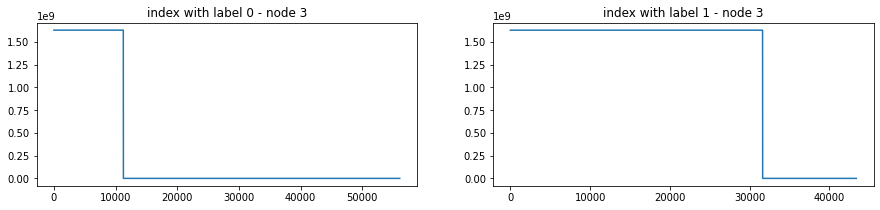

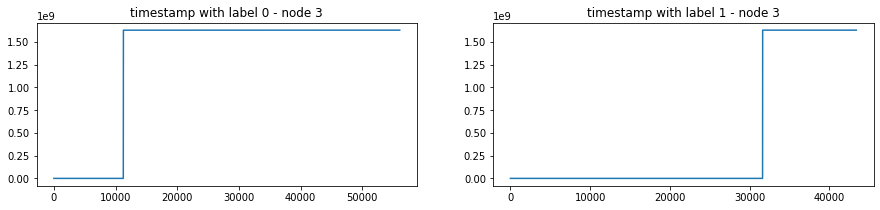

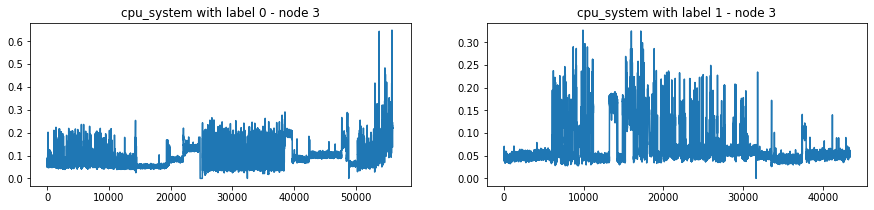

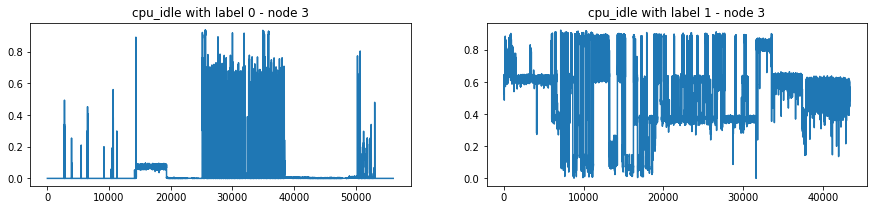

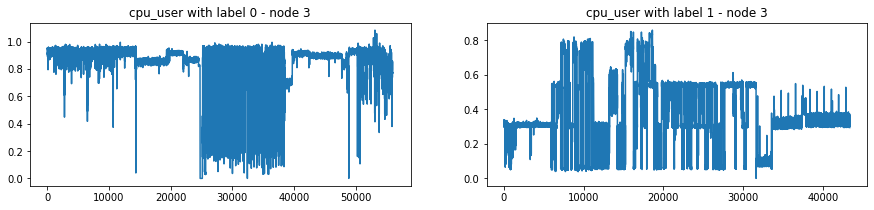

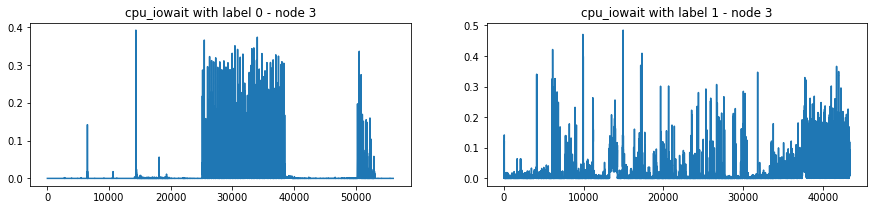

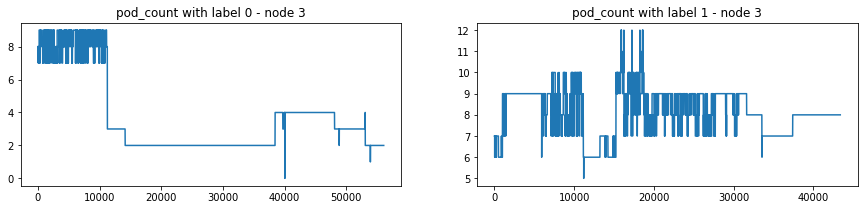

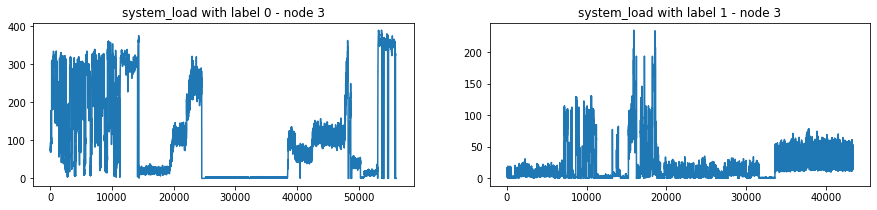

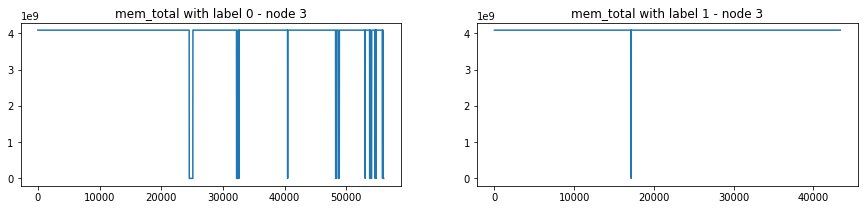

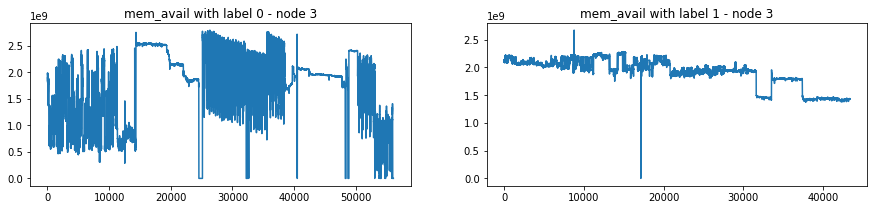

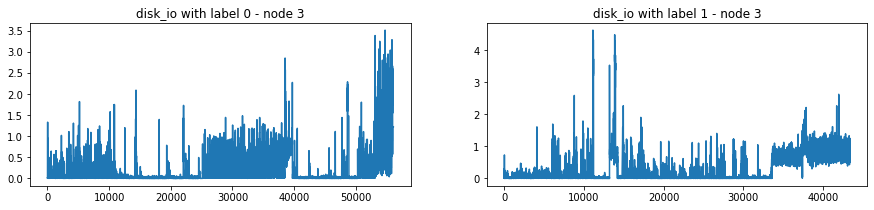

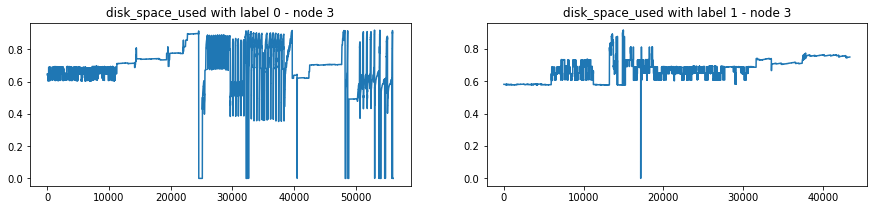

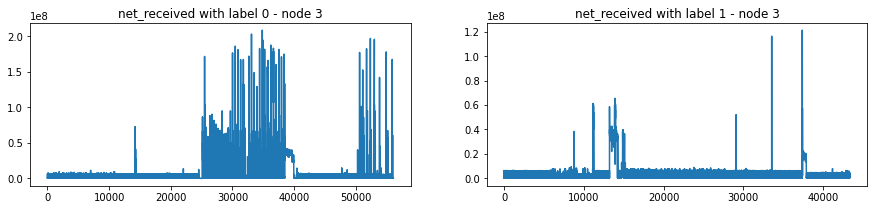

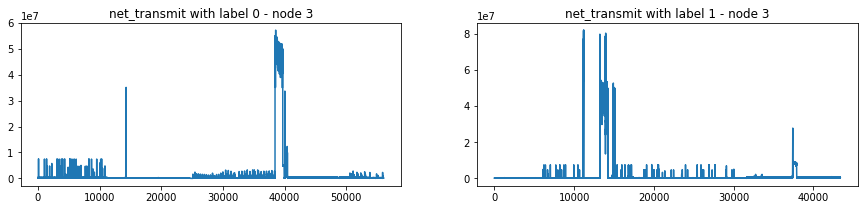

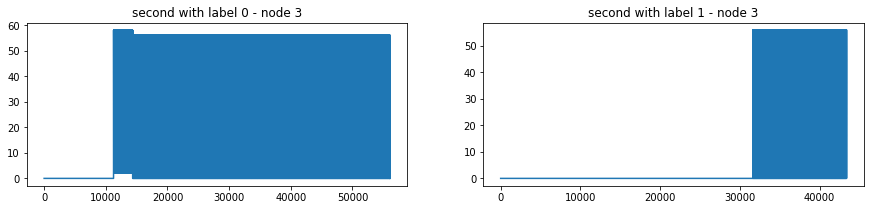

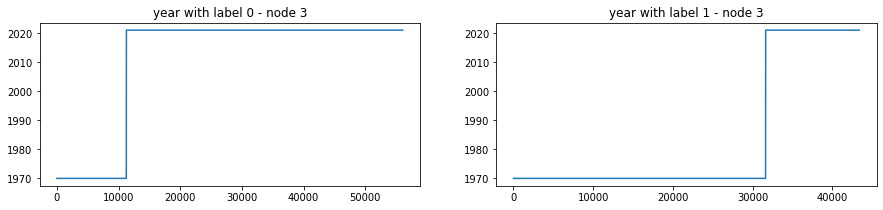

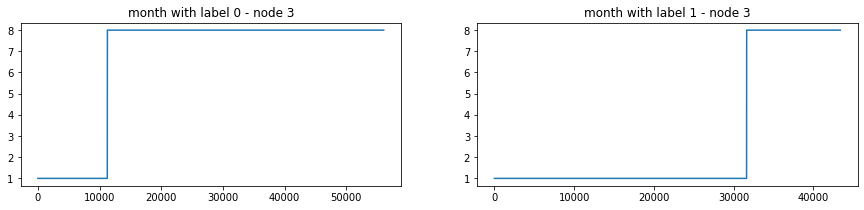

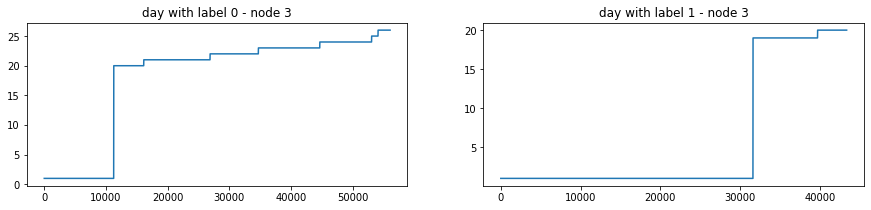

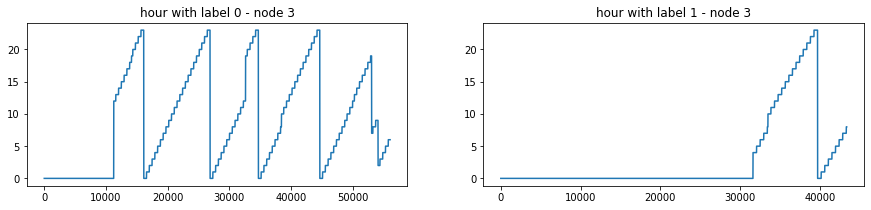

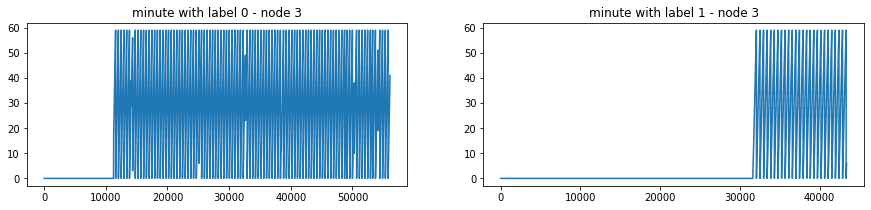

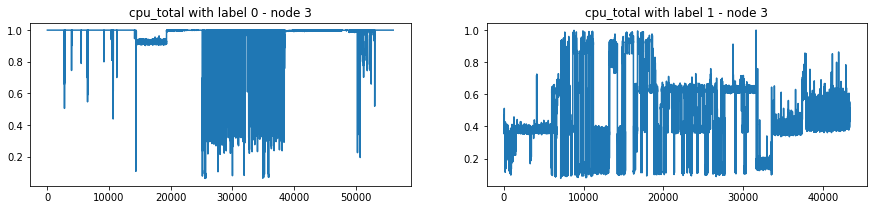

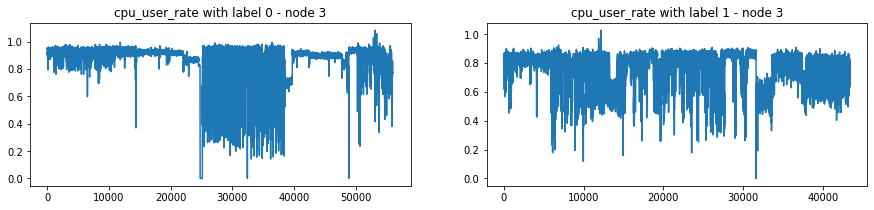

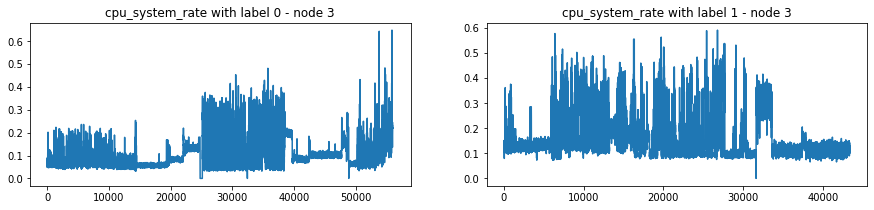

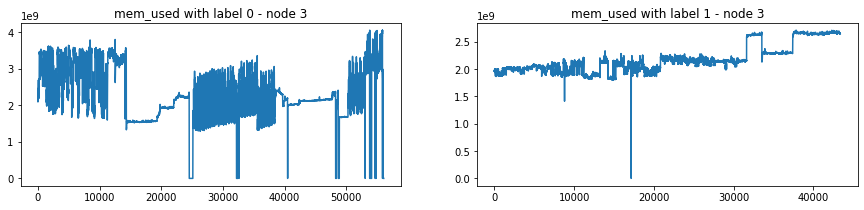

In [52]:
viewAllMetricsByNode(dataset,3)

# Make data becomes budgets
## CPU, Disk Space Used, Pod Count

In [53]:
cpuMax=1
cpuMin=0
cpuStep=5

dataset['cpu_system_bg'] = dataset['cpu_system'].apply(lambda x: groupDataSubset(x,cpuMax,cpuMin,cpuStep))
dataset['cpu_total_bg'] = dataset['cpu_total'].apply(lambda x: groupDataSubset(x,cpuMax,cpuMin,cpuStep))
dataset['cpu_idle_bg'] = dataset['cpu_idle'].apply(lambda x: groupDataSubset(x,cpuMax,cpuMin,cpuStep))
dataset['cpu_user_bg'] = dataset['cpu_user'].apply(lambda x: groupDataSubset(x,cpuMax,cpuMin,cpuStep))
dataset['cpu_iowait_bg'] = dataset['cpu_iowait'].apply(lambda x: groupDataSubset(x,cpuMax,cpuMin,cpuStep))

diskMax=1
diskMin=0
step=5

dataset['disk_space_used_bg'] = dataset['disk_space_used'].apply(lambda x: groupDataSubset(x,diskMax,diskMin,step))

podCountMax = dataset["pod_count"].max()
podCountMin = dataset["pod_count"].min()

dataset['pod_count_bg'] = dataset['pod_count'].apply(lambda x: groupDataSubset(x,podCountMax,podCountMin,step))


## RAM

In [54]:
def updateMemTotal(n,maxValue,row):
    if row["node"]==n:
        return maxValue
    return row["mem_total"]

for n in list(dataset["node"].unique()):
    cksn = dataset[dataset["node"]==n]
    maxValue = dataset["mem_total"].max()
    dataset["mem_total"] = dataset.apply(lambda row: updateMemTotal(n,maxValue,row), axis=1)

dataset["mem_used_rate"] = dataset["mem_used"] / dataset["mem_total"]
dataset["mem_avail_rate"] = dataset["mem_avail"] / dataset["mem_total"]

memMax=1
memMin=0
step=5
dataset['mem_used_rate_bg'] = dataset['mem_used_rate'].apply(lambda x: groupDataSubset(x,memMax,memMin,step))


## Net receive - Net Transmit - System Load - Disk IO - spit with 10 budgets => Not sure

In [55]:
def groupWithItsMaxMin(colName,step):
    vMax = dataset[colName].max()
    vMin = dataset[colName].min()
    dataset[colName+'_bg'] = dataset[colName].apply(lambda x: groupDataSubset(x,vMax,vMin,step))

groupWithItsMaxMin('net_received',10)
groupWithItsMaxMin('net_transmit',10)
groupWithItsMaxMin('disk_io',10)
groupWithItsMaxMin('system_load',10)

--- index
-------Label=0:max 1630328100.0  min: 4546.0
-------Label=1:max 1630656540.0  min: 88534.0
--- timestamp
-------Label=0:max 1629960060.0  min: 0.0
-------Label=1:max 1629446816.0  min: 0.0
--- cpu_system
-------Label=0:max 0.6477777777778101  min: 0.0
-------Label=1:max 0.32666666666627864  min: 0.0
--- cpu_idle
-------Label=0:max 0.9373333333333373  min: 0.0
-------Label=1:max 0.9233333333337215  min: 0.0
--- cpu_user
-------Label=0:max 1.0839999999986807  min: 0.0
-------Label=1:max 0.857999999995809  min: 0.0
--- cpu_iowait
-------Label=0:max 0.3926666666666885  min: 0.0
-------Label=1:max 0.48466666666666547  min: 0.0
--- pod_count
-------Label=0:max 9.0  min: 0.0
-------Label=1:max 12.0  min: 5.0
--- system_load
-------Label=0:max 389.44  min: 0.0
-------Label=1:max 235.07  min: 0.0
--- mem_total
-------Label=0:max 4086054912.0  min: 4086054912.0
-------Label=1:max 4086054912.0  min: 4086054912.0
--- mem_avail
-------Label=0:max 2799693824.0  min: 0.0
-------Label=1:max 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


--- cpu_system_rate
-------Label=0:max 0.6477777777778101  min: 0.0
-------Label=1:max 0.5904761904760164  min: 0.0
--- mem_used
-------Label=0:max 4056338432.0  min: 0.0
-------Label=1:max 2713276416.0  min: 0.0
--- cpu_system_bg
-------Label=0:max 4  min: 0
-------Label=1:max 2  min: 0
--- cpu_total_bg
-------Label=0:max 5  min: 1
-------Label=1:max 5  min: 1
--- cpu_idle_bg
-------Label=0:max 5  min: 0
-------Label=1:max 5  min: 0
--- cpu_user_bg
-------Label=0:max 5  min: 0
-------Label=1:max 5  min: 0
--- cpu_iowait_bg
-------Label=0:max 2  min: 0
-------Label=1:max 3  min: 0
--- disk_space_used_bg
-------Label=0:max 5  min: 0
-------Label=1:max 5  min: 0
--- pod_count_bg
-------Label=0:max 2  min: 0
-------Label=1:max 3  min: 1
--- mem_used_rate
-------Label=0:max 0.9927273419863428  min: 0.0
-------Label=1:max 0.6640332727863252  min: 0.0
--- mem_avail_rate
-------Label=0:max 0.6851826234096386  min: 0.0
-------Label=1:max 0.6541703255504364  min: 0.0
--- mem_used_rate_bg
------

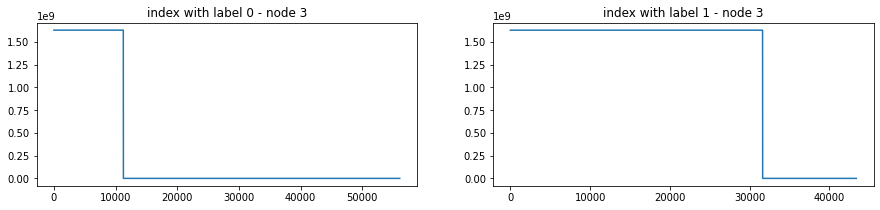

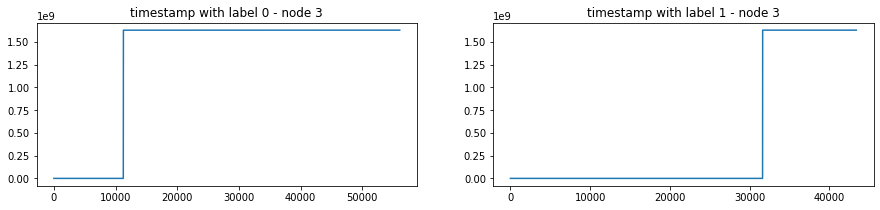

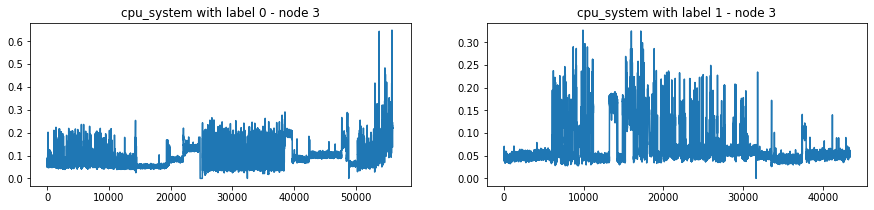

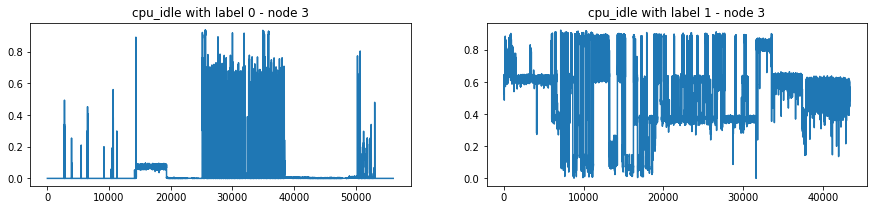

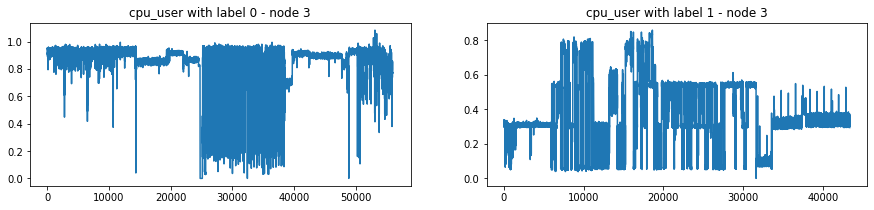

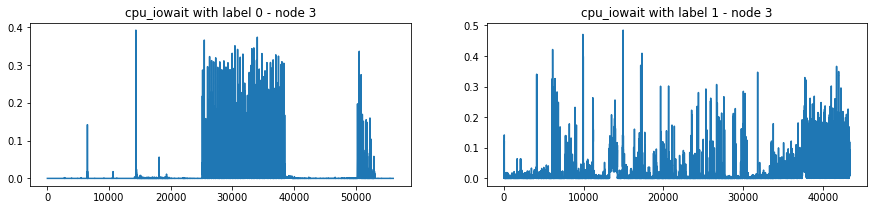

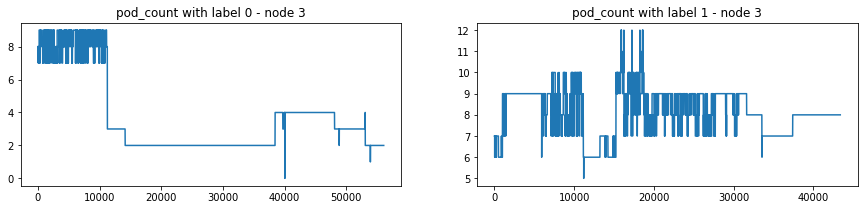

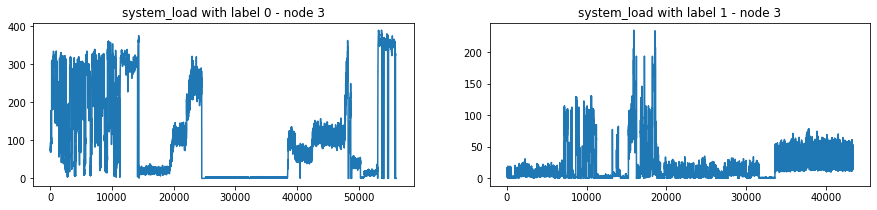

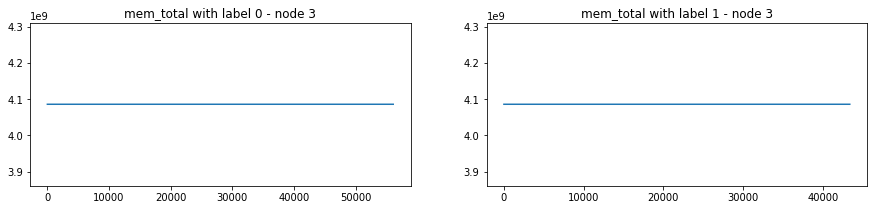

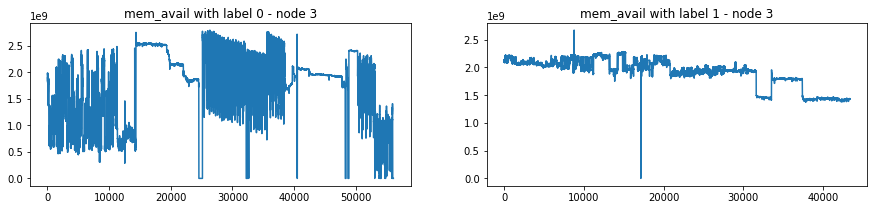

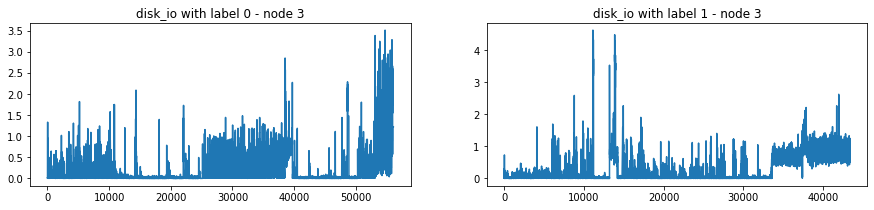

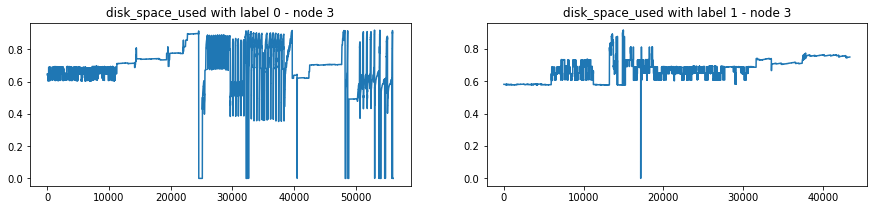

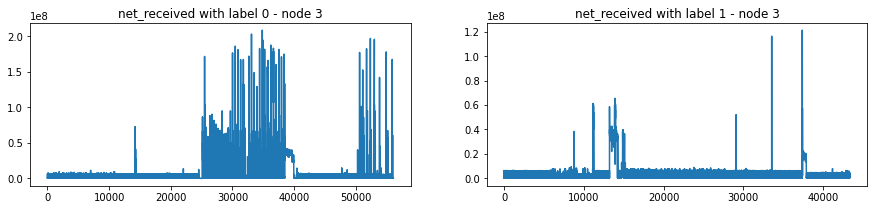

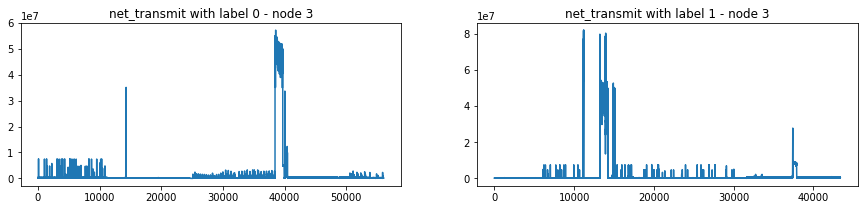

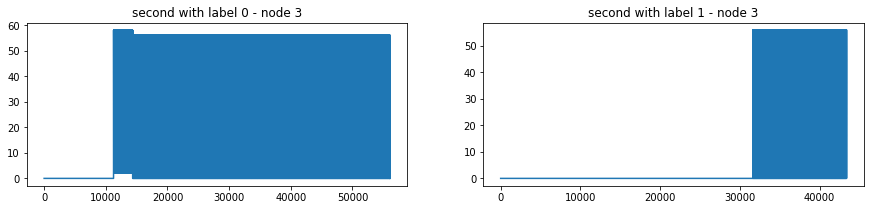

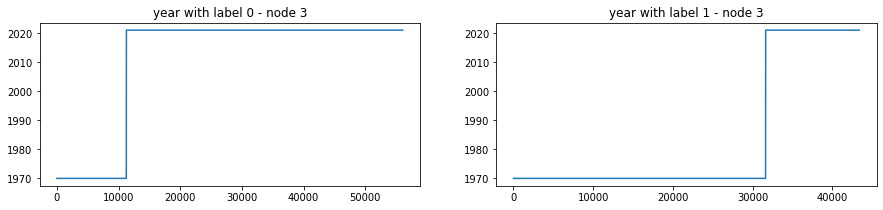

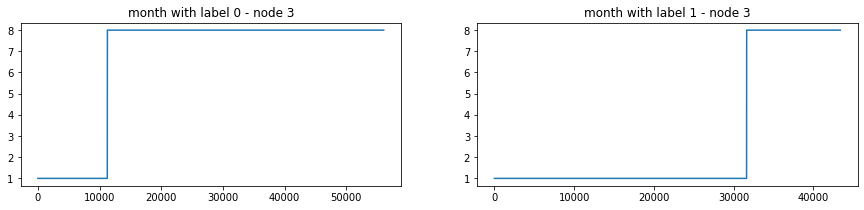

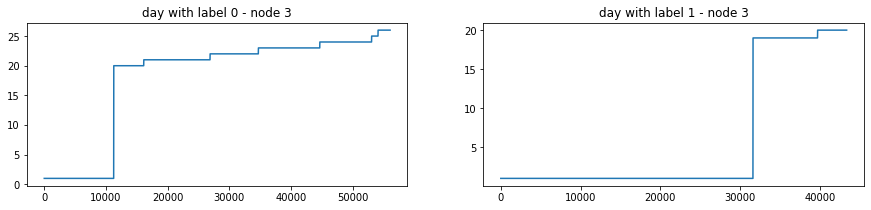

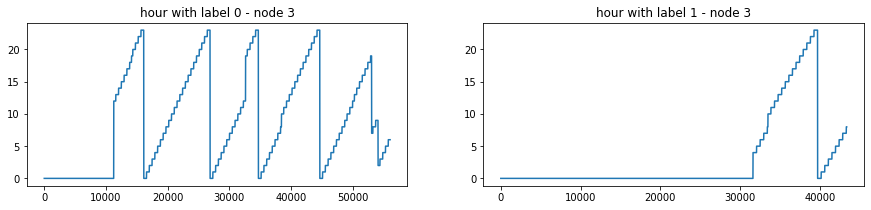

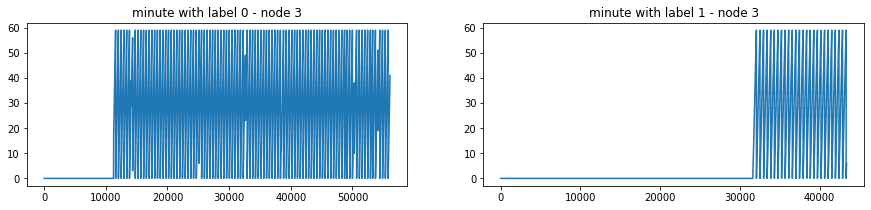

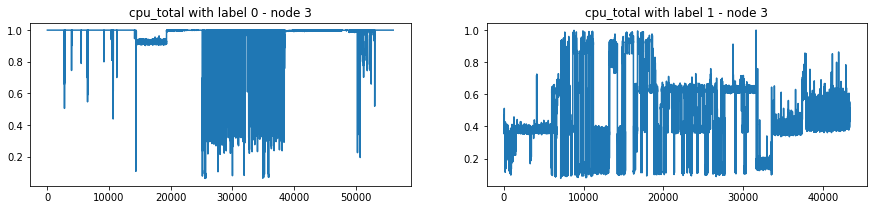

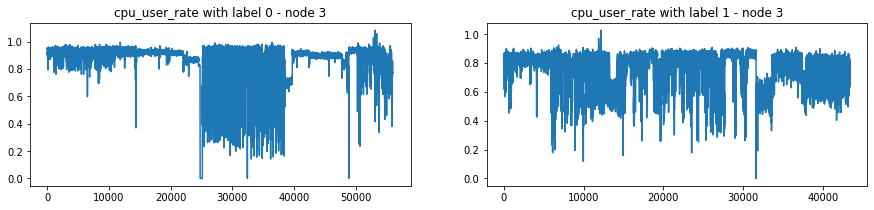

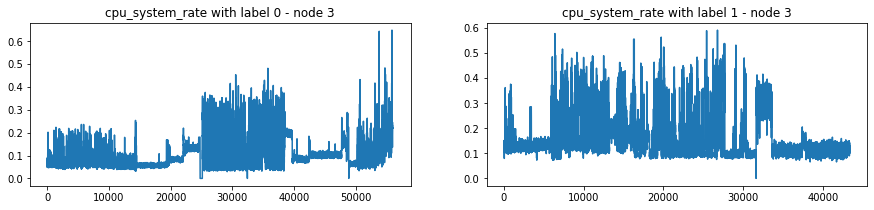

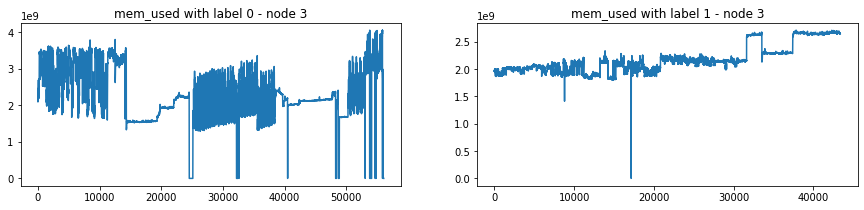

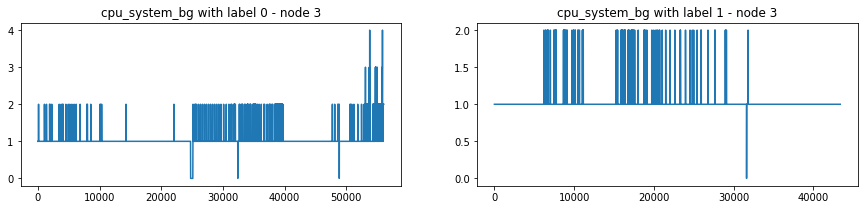

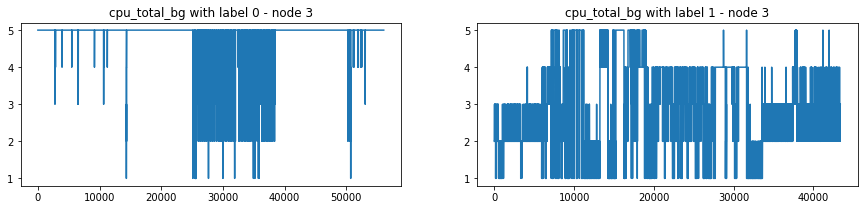

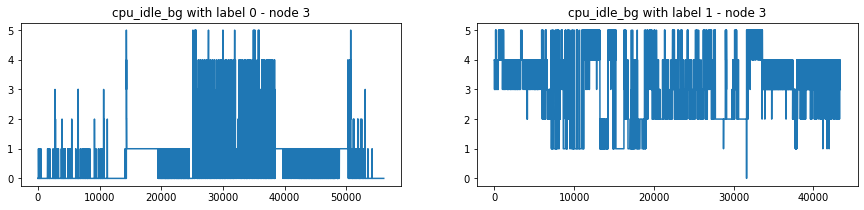

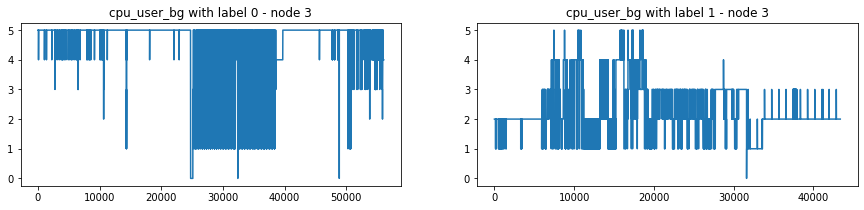

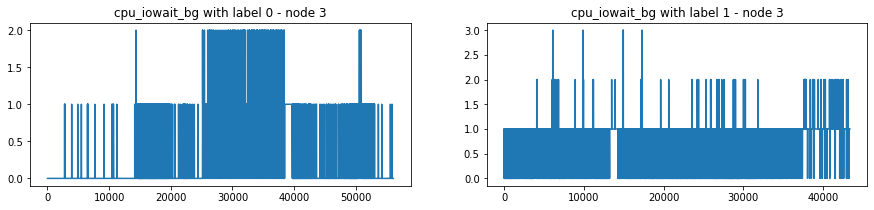

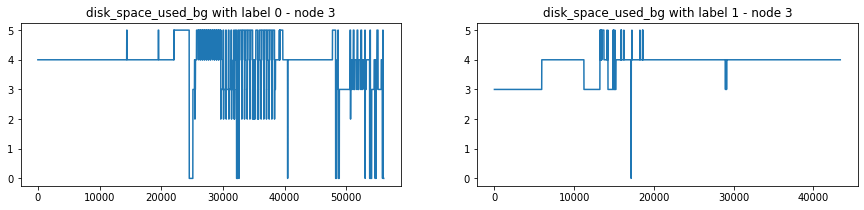

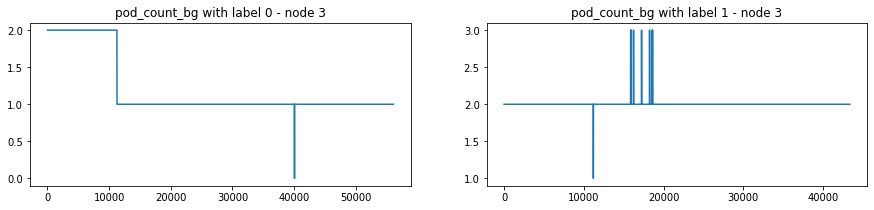

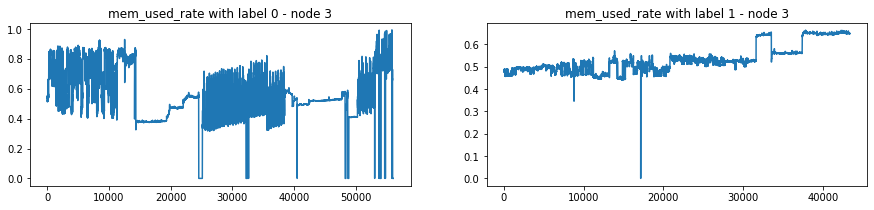

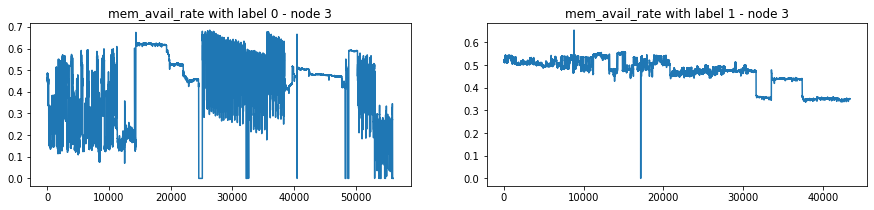

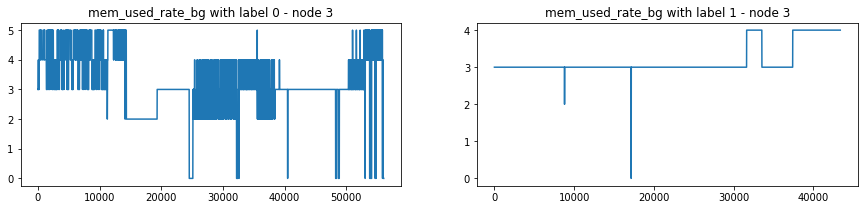

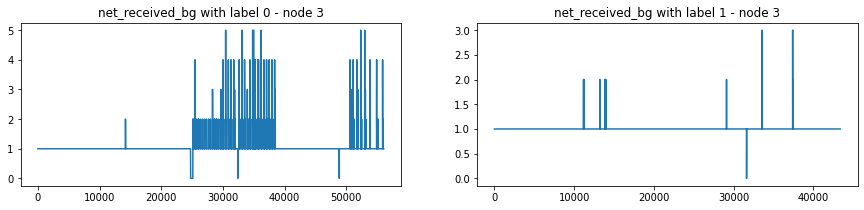

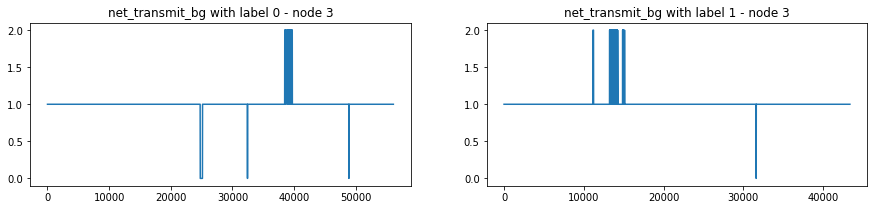

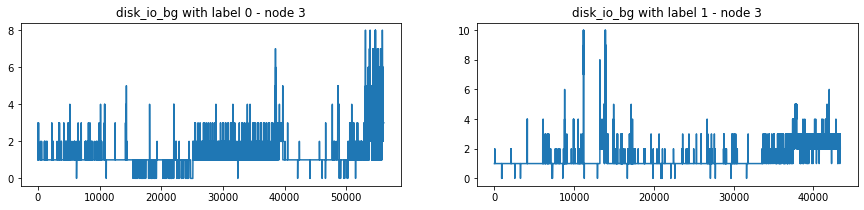

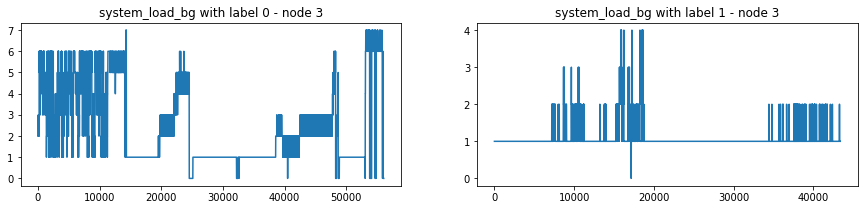

In [56]:
viewAllMetricsByNode(dataset,3)

In [57]:
list(dataset.columns.values)

['index',
 'timestamp',
 'cpu_system',
 'cpu_idle',
 'cpu_user',
 'cpu_iowait',
 'pod_count',
 'system_load',
 'mem_total',
 'mem_avail',
 'disk_io',
 'disk_space_used',
 'net_received',
 'net_transmit',
 'node',
 'label',
 'second',
 'year',
 'month',
 'day',
 'hour',
 'minute',
 'cpu_total',
 'cpu_user_rate',
 'cpu_system_rate',
 'mem_used',
 'cpu_system_bg',
 'cpu_total_bg',
 'cpu_idle_bg',
 'cpu_user_bg',
 'cpu_iowait_bg',
 'disk_space_used_bg',
 'pod_count_bg',
 'mem_used_rate',
 'mem_avail_rate',
 'mem_used_rate_bg',
 'net_received_bg',
 'net_transmit_bg',
 'disk_io_bg',
 'system_load_bg']

## Normalize data

In [58]:
datasetnorm = normalizeColumn(dataset)
# datasetnorm = dataset

0   index
1   timestamp
2   cpu_system
3   cpu_idle
4   cpu_user
5   cpu_iowait
6   pod_count
7   system_load
8   mem_total
9   mem_avail
10   disk_io
11   disk_space_used
12   net_received
13   net_transmit


## Overview of data

In [59]:
# datasetnormwdiff = mergeWithDiff(datasetnorm)

In [60]:
datasetnorm

,index,timestamp,cpu_system,cpu_idle,cpu_user,cpu_iowait,pod_count,system_load,mem_total,mem_avail,...,cpu_iowait_bg,disk_space_used_bg,pod_count_bg,mem_used_rate,mem_avail_rate,mem_used_rate_bg,net_received_bg,net_transmit_bg,disk_io_bg,system_load_bg
0,-0.878143,0.877994,-1.109678,1.088068,-1.019622,-0.247345,-0.665480,-0.427954,NaN,1.026640,...,1,3,2,0.467816,0.532181,3,1,1,1,1
1,-0.878143,0.877994,-1.109678,1.088068,-1.019622,-0.247345,-0.665480,-0.427954,NaN,1.026640,...,1,3,2,0.467816,0.532181,3,1,1,1,1
2,-0.878143,0.877994,-0.906071,1.058422,-1.041554,-0.150130,-0.665480,-0.428214,NaN,1.026093,...,1,3,2,0.467873,0.532124,3,1,1,1,1
3,-0.878143,0.877994,-0.906071,1.058422,-1.041554,-0.150130,-0.665480,-0.428214,NaN,1.026093,...,1,3,2,0.467873,0.532124,3,1,1,1,1
4,-0.878143,0.877994,-1.089974,1.093806,-1.043642,-0.259497,-0.665480,-0.428605,NaN,1.027369,...,0,3,2,0.467740,0.532257,3,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295507,-0.877933,0.877993,-1.582572,-1.511253,-1.184634,-0.259497,-1.503167,-0.429517,NaN,-4.063134,...,0,0,1,0.000000,0.000000,0,0,0,0,0
295508,-0.877933,0.877993,-1.582572,-1.511253,-1.184634,-0.259497,-1.503167,-0.429517,NaN,-4.063134,...,0,0,1,0.000000,0.000000,0,0,0,0,0
295509,-0.877933,0.877993,-1.582572,-1.511253,-1.184634,-0.259497,-1.503167,-0.429517,NaN,-4.063134,...,0,0,1,0.000000,0.000000,0,0,0,0,0
295510,-0.877933,0.877993,-1.582572,-1.511253,-1.184634,-0.259497,-1.503167,-0.429517,NaN,-4.063134,...,0,0,1,0.000000,0.000000,0,0,0,0,0


--- index
-------Label=0:max 1.138934257721388  min: -0.8781377349897448
-------Label=1:max 1.139340610879729  min: -0.8780338231974456
--- timestamp
-------Label=0:max 0.8784687348271285  min: -1.138898562035052
-------Label=1:max 0.8778335035191229  min: -1.138898562035052
--- cpu_system
-------Label=0:max 11.181175544001345  min: -1.5825716986493958
-------Label=1:max 4.854034972593611  min: -1.5825716986493958
--- cpu_idle
-------Label=0:max 1.1779640733739352  min: -1.5112533487622184
-------Label=1:max 1.1377979525607704  min: -1.5112533487622184
--- cpu_user
-------Label=0:max 2.2117008889541503  min: -1.1846341020636766
-------Label=1:max 1.5036089074221246  min: -1.1846341020636766
--- cpu_iowait
-------Label=0:max 14.055398360460492  min: -0.2594972072250956
-------Label=1:max 17.40931277190363  min: -0.2594972072250956
--- pod_count
-------Label=0:max -0.03721461266427863  min: -1.9220104072069017
-------Label=1:max 0.5910506521832624  min: -0.8749016324610001
--- system_loa

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


--- cpu_total_bg
-------Label=0:max 5  min: 1
-------Label=1:max 5  min: 1
--- cpu_idle_bg
-------Label=0:max 5  min: 0
-------Label=1:max 5  min: 0
--- cpu_user_bg
-------Label=0:max 5  min: 0
-------Label=1:max 5  min: 0
--- cpu_iowait_bg
-------Label=0:max 2  min: 0
-------Label=1:max 3  min: 0
--- disk_space_used_bg
-------Label=0:max 5  min: 0
-------Label=1:max 5  min: 0
--- pod_count_bg
-------Label=0:max 2  min: 0
-------Label=1:max 3  min: 1
--- mem_used_rate
-------Label=0:max 0.9927273419863428  min: 0.0
-------Label=1:max 0.6640332727863252  min: 0.0
--- mem_avail_rate
-------Label=0:max 0.6851826234096386  min: 0.0
-------Label=1:max 0.6541703255504364  min: 0.0
--- mem_used_rate_bg
-------Label=0:max 5  min: 0
-------Label=1:max 4  min: 0
--- net_received_bg
-------Label=0:max 5  min: 0
-------Label=1:max 3  min: 0
--- net_transmit_bg
-------Label=0:max 2  min: 0
-------Label=1:max 2  min: 0
--- disk_io_bg
-------Label=0:max 8  min: 0
-------Label=1:max 10  min: 0
--- sys

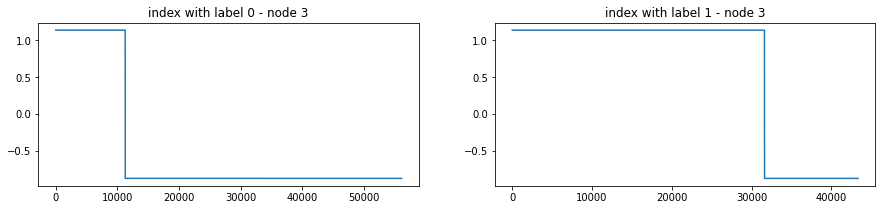

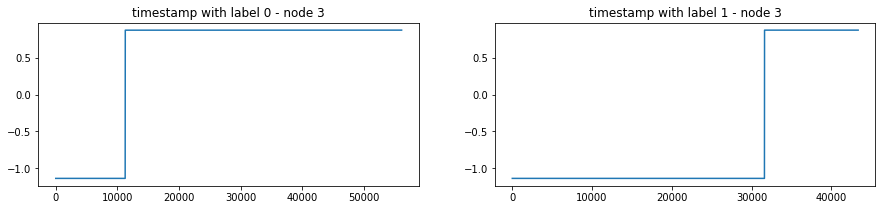

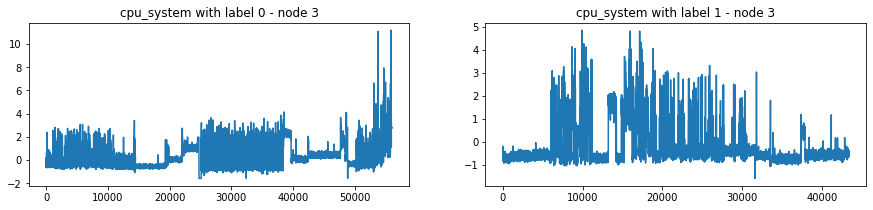

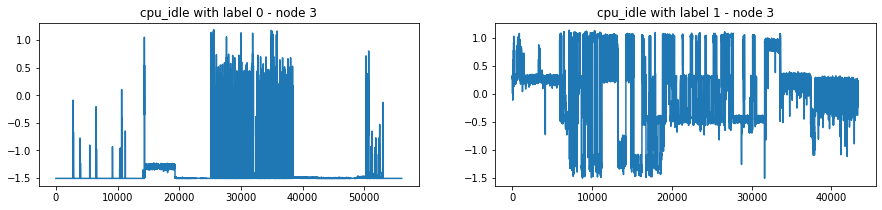

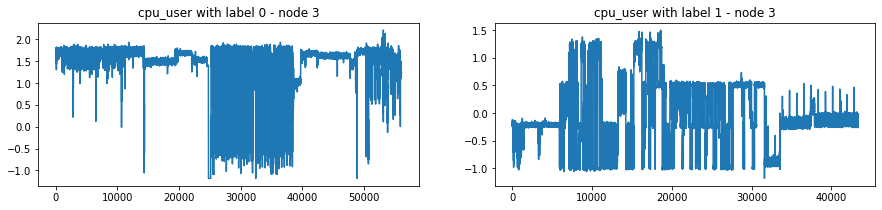

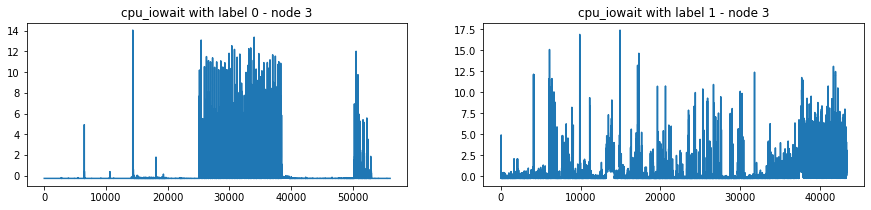

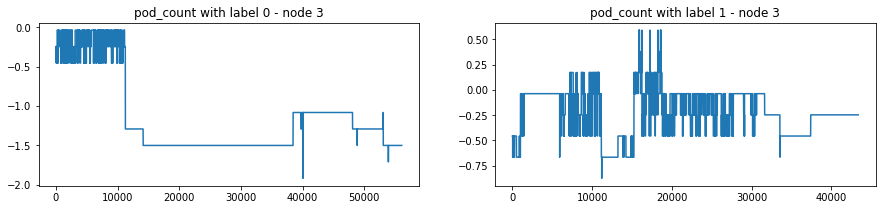

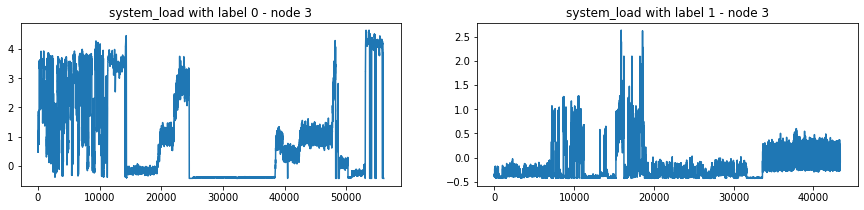

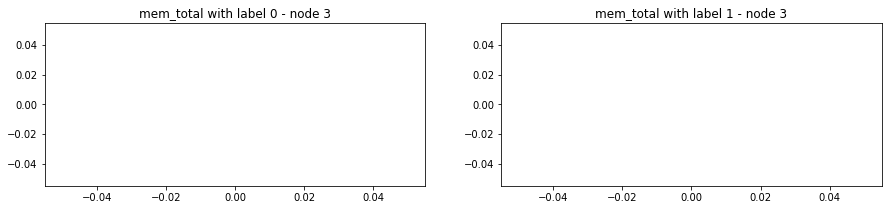

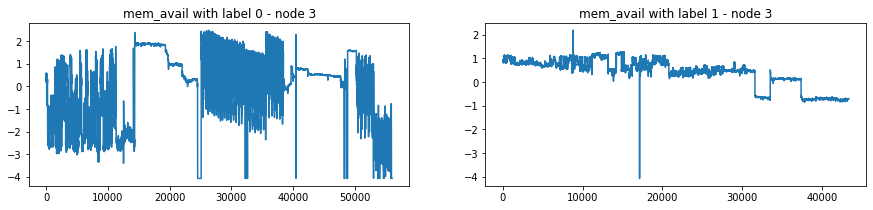

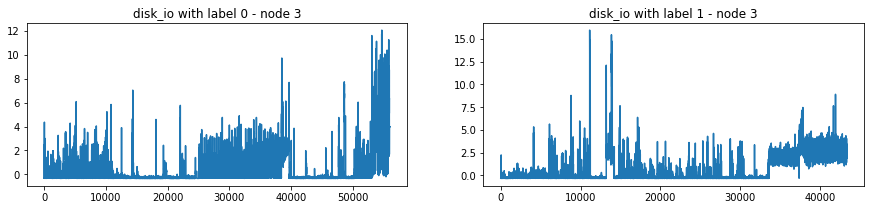

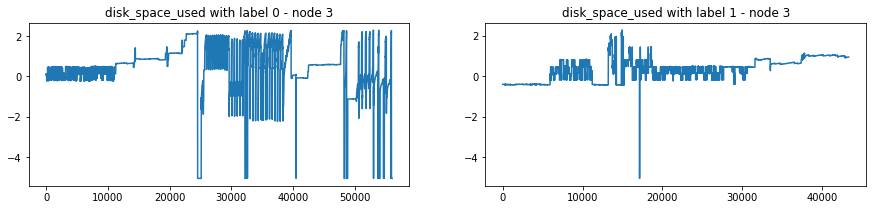

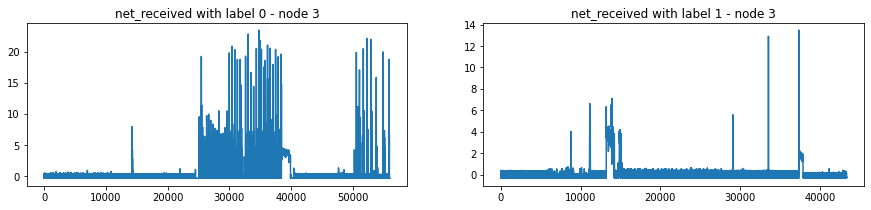

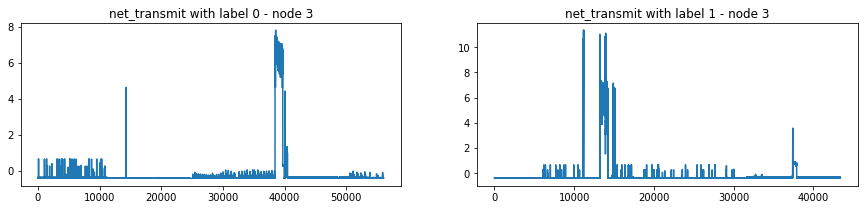

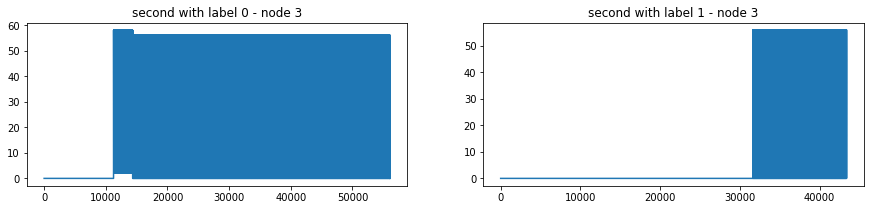

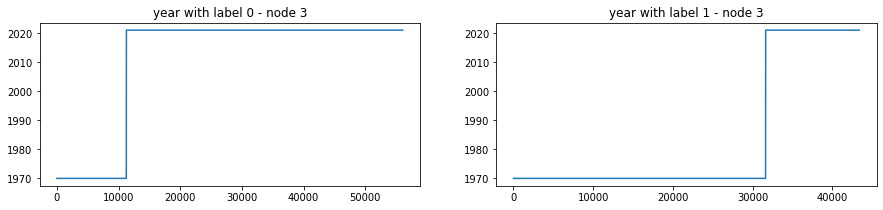

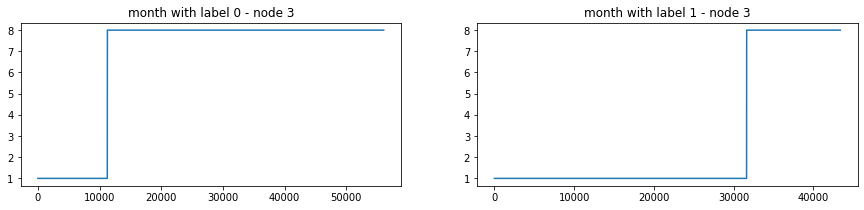

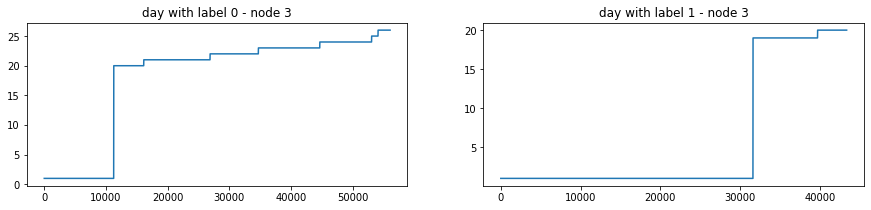

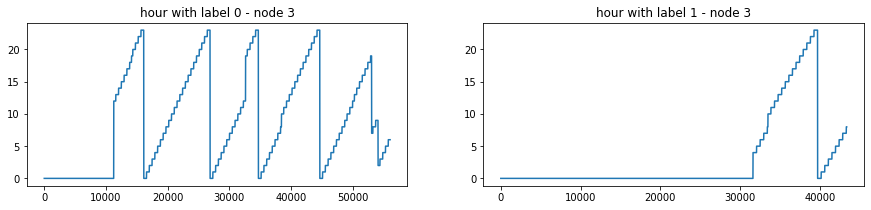

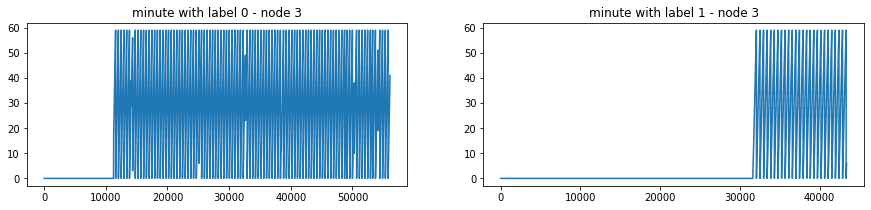

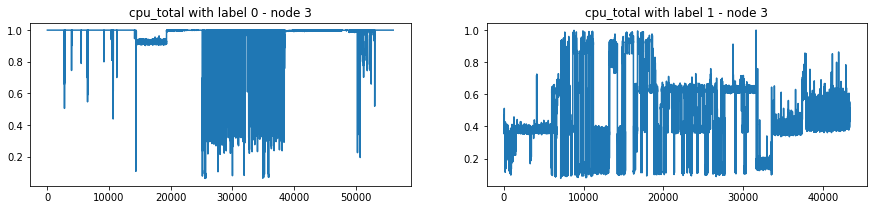

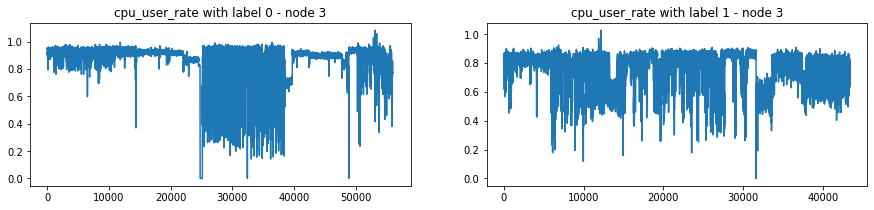

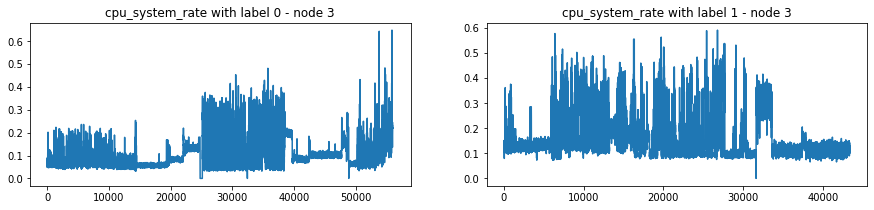

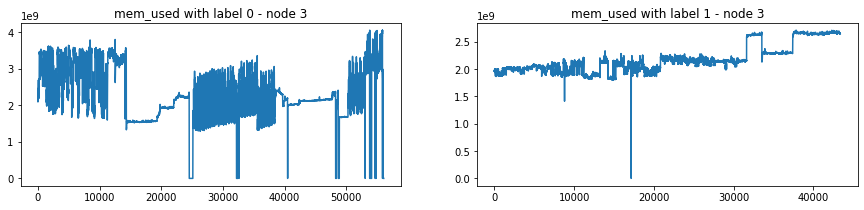

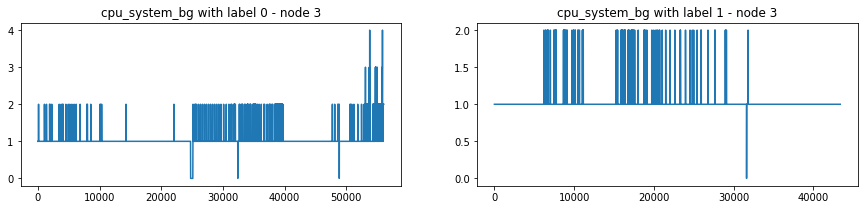

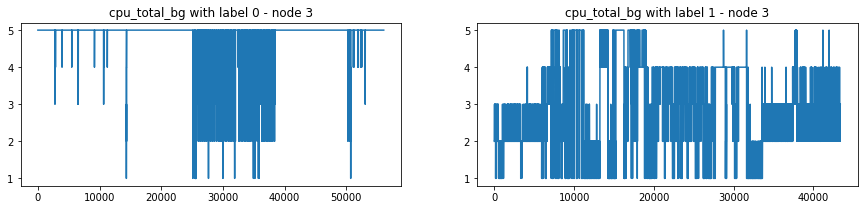

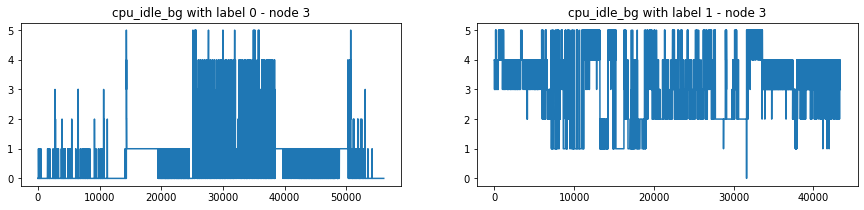

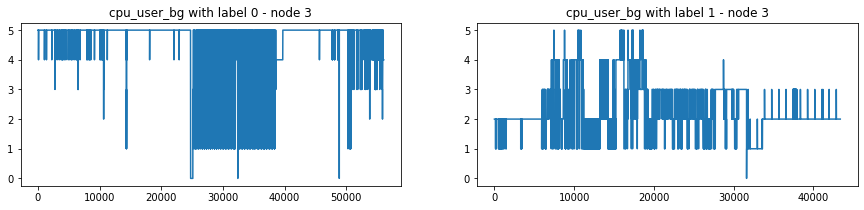

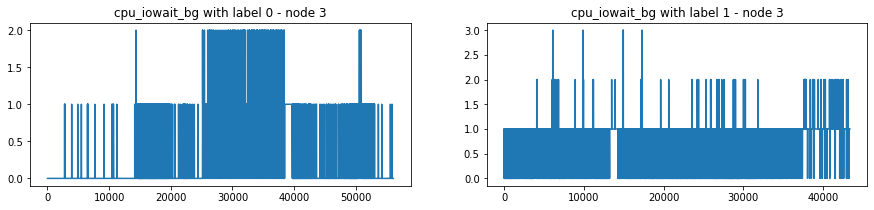

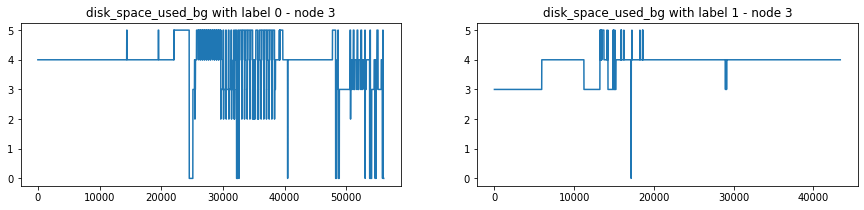

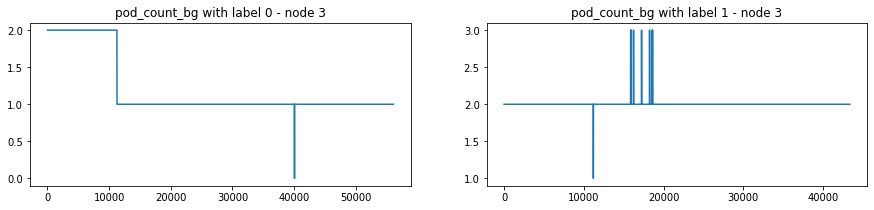

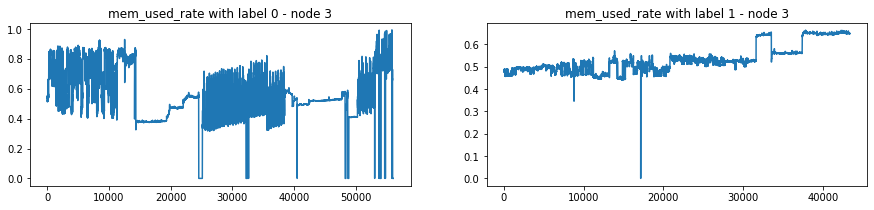

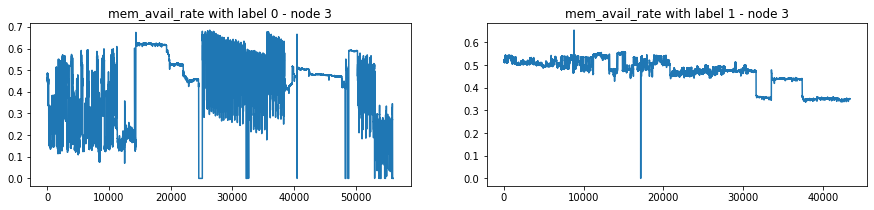

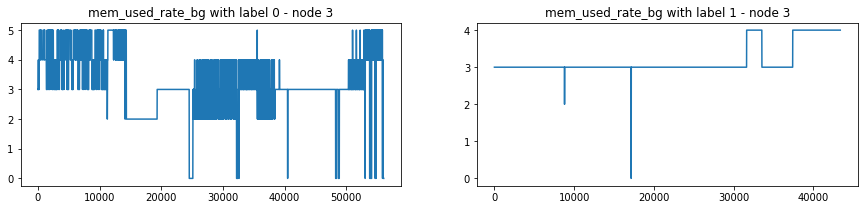

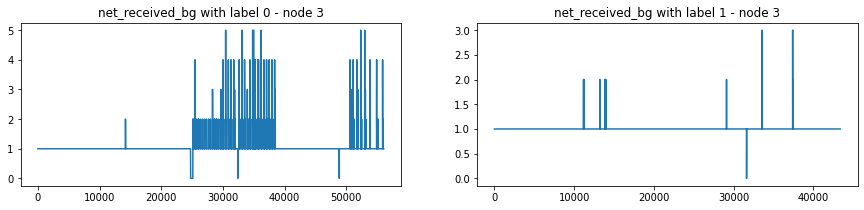

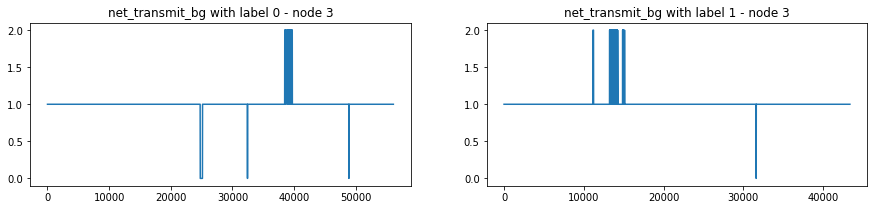

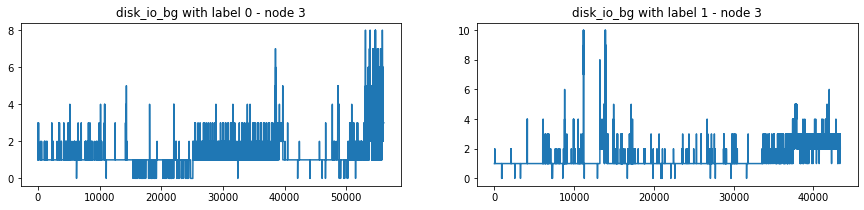

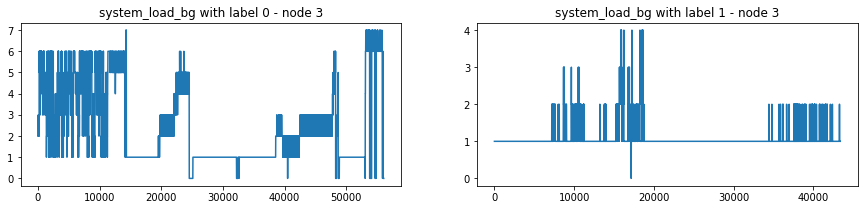

In [61]:
viewAllMetricsByNode(datasetnorm,3)

In [62]:
correlation_matrix = datasetnorm.corr()
correlation_matrix["label"]

index                 0.229007
timestamp            -0.229045
cpu_system           -0.137528
cpu_idle              0.680844
cpu_user             -0.713590
cpu_iowait            0.014753
pod_count             0.549687
system_load          -0.497513
mem_total                  NaN
mem_avail            -0.006702
disk_io              -0.081445
disk_space_used      -0.229305
net_received         -0.037779
net_transmit          0.111801
node                 -0.588487
label                 1.000000
second               -0.168672
year                 -0.229020
month                -0.229020
day                  -0.249545
hour                 -0.171259
minute               -0.172394
cpu_total            -0.680844
cpu_user_rate        -0.462609
cpu_system_rate       0.467924
mem_used              0.107679
cpu_system_bg         0.046019
cpu_total_bg         -0.623495
cpu_idle_bg           0.672378
cpu_user_bg          -0.737099
cpu_iowait_bg         0.369358
disk_space_used_bg   -0.265919
pod_coun

<AxesSubplot:>

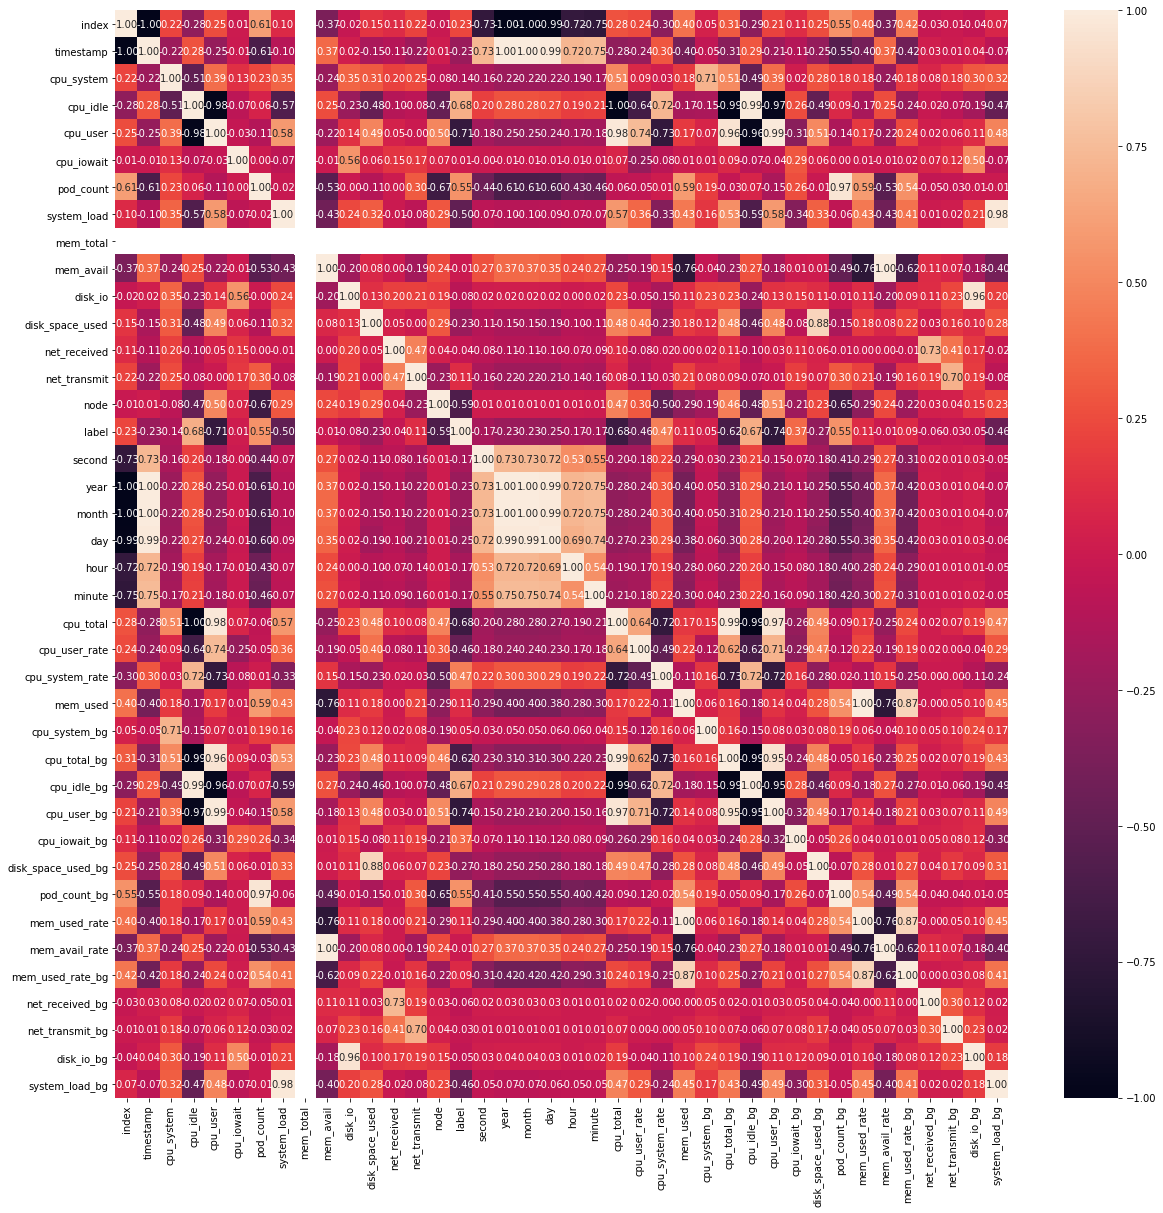

In [63]:
plt.figure(figsize=(20,20))
sn.heatmap(datasetnorm.corr(), annot=True, fmt='.2f')

correlation matrix interpretation:
- CPU Idle (cpu free) increase, label increase and vice versa
- CPU user / CPU total increase, label decrease => If we still have more CPU, label is 1, if users are using more CPU, label is 0
- Pod count increases, label increases
- System load increases, label decrease => System gets more stress => label is 0
- disk space used increase, label decrease => We have less free disk => label is 0

# Rebalance data

In [66]:
def resampleData(dataset,label):
    dataX = dataset.drop(label, axis=1)
    dataY = dataset[label]
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(dataX, dataY)
    result = pd.concat([X_res, y_res], axis=1)
    return result

# XGBoost

In [67]:
# !apt-get update -y
# !apt-get install build-essential -y
# !pip3 install cmake --upgrade

In [68]:
# !pip3 install xgboost --upgrade

In [69]:
#In case it does not work
# !rm -rf /root/.local/lib/python3.6/site-packages/xgboost
# !rm -rf xgboost
# !git clone --recursive https://github.com/dmlc/xgboost.git
# !cd xgboost && make
# !cd xgboost/python-package && python3 setup.py install --user

In [70]:
import xgboost

In [71]:
datasetnorm = normalizeColumn(dataset)

0   index
1   timestamp
2   cpu_system
3   cpu_idle
4   cpu_user
5   cpu_iowait
6   pod_count
7   system_load
8   mem_total
9   mem_avail
10   disk_io
11   disk_space_used
12   net_received
13   net_transmit


In [72]:
nDatasetNormKnn = datasetnorm.drop("year", axis=1).drop("month", axis=1).drop("day", axis=1).drop("hour", axis=1).drop("minute", axis=1).drop("second", axis=1).drop("timestamp", axis=1).drop("node", axis=1).drop("index", axis=1)
nDatasetNormKnn = nDatasetNormKnn.drop("cpu_system", axis=1).drop("cpu_idle", axis=1).drop("cpu_user", axis=1).drop("cpu_iowait", axis=1)
nDatasetNormKnn = nDatasetNormKnn.drop("cpu_user_rate", axis=1).drop("cpu_system_rate", axis=1).drop("cpu_total", axis=1)
nDatasetNormKnn = nDatasetNormKnn.drop("pod_count", axis=1).drop("disk_space_used", axis=1)
nDatasetNormKnn = nDatasetNormKnn.drop("mem_used", axis=1).drop("mem_used_rate", axis=1).drop("mem_avail_rate", axis=1)
nDatasetNormKnn = nDatasetNormKnn.drop("mem_total", axis=1).drop("mem_avail", axis=1)
nDatasetNormKnn = nDatasetNormKnn.drop("net_received", axis=1).drop("net_transmit", axis=1)
nDatasetNormKnn = nDatasetNormKnn.drop("system_load", axis=1).drop("disk_io", axis=1)


In [73]:
list(nDatasetNormKnn.columns.values)

['label',
 'cpu_system_bg',
 'cpu_total_bg',
 'cpu_idle_bg',
 'cpu_user_bg',
 'cpu_iowait_bg',
 'disk_space_used_bg',
 'pod_count_bg',
 'mem_used_rate_bg',
 'net_received_bg',
 'net_transmit_bg',
 'disk_io_bg',
 'system_load_bg']

In [74]:
nDatasetNormKnn

,label,cpu_system_bg,cpu_total_bg,cpu_idle_bg,cpu_user_bg,cpu_iowait_bg,disk_space_used_bg,pod_count_bg,mem_used_rate_bg,net_received_bg,net_transmit_bg,disk_io_bg,system_load_bg
0,1,1,1,5,1,1,3,2,3,1,1,1,1
1,1,1,1,5,1,1,3,2,3,1,1,1,1
2,1,1,1,5,1,1,3,2,3,1,1,1,1
3,1,1,1,5,1,1,3,2,3,1,1,1,1
4,1,1,1,5,1,0,3,2,3,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295507,0,0,5,0,0,0,0,1,0,0,0,0,0
295508,0,0,5,0,0,0,0,1,0,0,0,0,0
295509,0,0,5,0,0,0,0,1,0,0,0,0,0
295510,0,0,5,0,0,0,0,1,0,0,0,0,0


In [75]:
rsDataset = resampleData(nDatasetNormKnn, "label")

In [76]:
list(rsDataset.columns.values)

['cpu_system_bg',
 'cpu_total_bg',
 'cpu_idle_bg',
 'cpu_user_bg',
 'cpu_iowait_bg',
 'disk_space_used_bg',
 'pod_count_bg',
 'mem_used_rate_bg',
 'net_received_bg',
 'net_transmit_bg',
 'disk_io_bg',
 'system_load_bg',
 'label']

In [77]:
rsDataset

,cpu_system_bg,cpu_total_bg,cpu_idle_bg,cpu_user_bg,cpu_iowait_bg,disk_space_used_bg,pod_count_bg,mem_used_rate_bg,net_received_bg,net_transmit_bg,disk_io_bg,system_load_bg,label
0,1,1,5,1,1,3,2,3,1,1,1,1,1
1,1,1,5,1,1,3,2,3,1,1,1,1,1
2,1,1,5,1,1,3,2,3,1,1,1,1,1
3,1,1,5,1,1,3,2,3,1,1,1,1,1
4,1,1,5,1,0,3,2,3,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
478841,1,5,1,5,1,5,1,3,1,1,1,1,0
478842,1,5,0,5,0,4,1,3,1,1,1,2,0
478843,1,5,0,5,0,4,2,4,1,1,1,3,0
478844,1,3,3,2,1,4,1,3,1,1,1,1,0


In [78]:
print(rsDataset["label"].value_counts())

1    239423
0    239423
Name: label, dtype: int64


In [79]:
def splitDataSetSKLearn(datasetnorms, testSplitPercent):
    dataAllX = datasetnorms.drop("label", axis=1)
    dataAllY = datasetnorms["label"]
    X_train, X_test, y_train, y_test = train_test_split(dataAllX, dataAllY, test_size=testSplitPercent)
    print("splitDataSet with sklearn")
    print("Train")
    print(X_train.shape)
    print("Train labels")
    print(y_train.value_counts())
    print("Test")
    print(X_test.shape)
    print("Test labels")
    print(y_test.value_counts())
    print("All")
    print(dataAllX.shape)
    return (dataAllX,dataAllY,X_train,y_train,X_test,y_test)
# splitDataSetSKLearn(nDatasetNormKnn,70)

In [88]:
(dataTrainM, dataTestM, dataTrainMX, dataTrainMY, dataTestMX, dataTestMY) = splitDataSetSKLearn(rsDataset, 0.9)

splitDataSet with sklearn
Train
(47884, 12)
Train labels
1    23956
0    23928
Name: label, dtype: int64
Test
(430962, 12)
Test labels
0    215495
1    215467
Name: label, dtype: int64
All
(478846, 12)


In [89]:
modelXGboost = xgboost.XGBRFClassifier(n_estimators=100,objective='binary:logistic')
modelXGboost.fit(dataTrainMX.to_numpy(), dataTrainMY.to_numpy())

/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:33:28] WARNING: /tmp/pip-build-5iihhz2k/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
                interaction_constraints='', max_delta_step=0, max_depth=6,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=100, n_jobs=6, num_parallel_tree=100,
                objective='binary:logistic', random_state=0, reg_alpha=0,
                scale_pos_weight=1, tree_method='exact', validate_parameters=1,
                verbosity=None)

In [82]:
featureList = list(dataTrainMX.columns.values)

In [90]:
y_pred = modelXGboost.predict(dataTestMX.to_numpy())
print("Accuracy score:",accuracy_score(dataTestMY, y_pred))

Accuracy score: 0.9988769311447413


In [91]:
y_pred

array([1, 0, 1, ..., 1, 1, 1])

In [92]:
#!apt-get install graphviz -y
# from xgboost import plot_tree

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

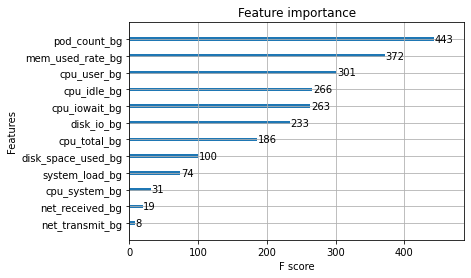

In [93]:
modelXGboost.get_booster().feature_names = featureList
xgboost.plot_importance(modelXGboost.get_booster())

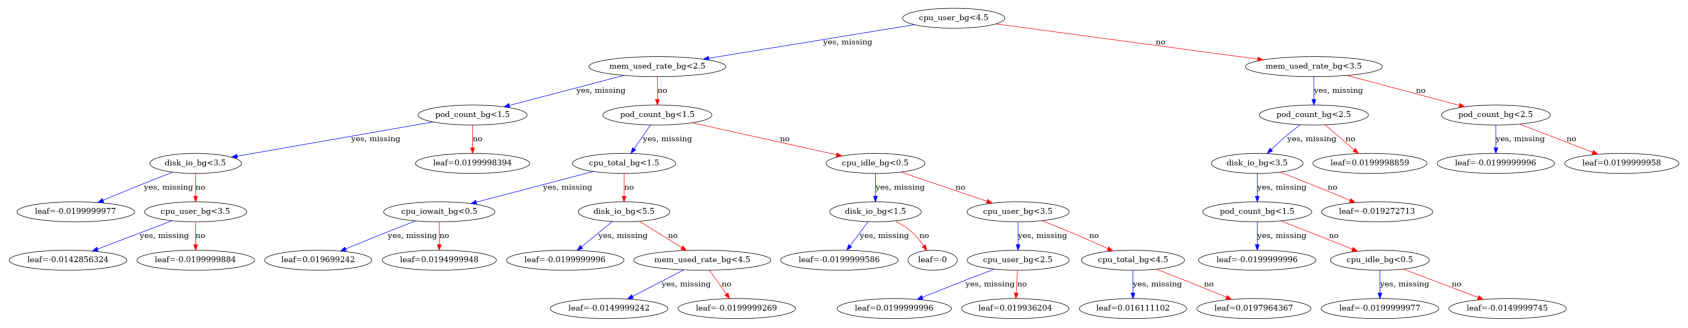

In [94]:
# plot_tree(modelXGboost)
# plt.figure(figsize=(200,200))  # set plot size (denoted in inches)
# plt.show()

fig, ax = plt.subplots(figsize=(30, 30))
xgboost.plot_tree(modelXGboost, num_trees=10, ax=ax)
plt.show()

Attribute leaf is the predicted value. In other words, if the evaluation of a tree model ends at that terminal node (aka leaf node), then this is the value that is returned.

For class 1 probability 1/(1+np.exp(-1* leaf_value))

leaf_value < 0 => Class 0

leaf_value > 0 => Class 1
